### Import necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil as su
import random as rd
import cv2

## Load data

In [2]:
%%bash
mkdir -p tmp_data
rm -rf tmp_data/*
mkdir -p tmp_data/train_set
mkdir -p tmp_data/test_set

## Separate training dataset

In [3]:
def separate_data(path, nb_elements=1):
    """
    Separate given data in `path` in two sets with `nb_elements` per class for test

    Parameters
    ----------
    path: str
        Path to directory where dataset files are stored.

    nb_elements: integer
        Defines the number of test images taken in each class of the dataset
    """
    labels_path = os.path.join(path, "labels.txt")
    images_path = path
    test_path = 'tmp_data/test_set'
    train_path = 'tmp_data/train_set'

    
    labels = np.empty((0, 1))
    names = np.empty((0, 1))
    with open(labels_path) as f:
        for current_label in f:
            if current_label == "\n":
                continue
            label, name = current_label.split(": ")
            labels = np.append(labels, label)
            names = np.append(names, name)

    for label in labels:
        pre_label = 'img_' + label + '_'
        curr_test_path = os.path.join(test_path, label)
        curr_train_path = os.path.join(train_path, label)
        os.makedirs(curr_test_path, exist_ok=True)
        os.makedirs(curr_train_path, exist_ok=True)

        current_path = os.path.join(images_path, label)
        datas = os.listdir(current_path)
        rd.shuffle(datas)

        count = 0
        for data in datas:
            data_path = os.path.join(current_path, data)
            if count < nb_elements:
                su.copyfile(data_path, os.path.join(curr_test_path, pre_label + str(count) + '.png'))
            else:
                su.copyfile(data_path, os.path.join(curr_train_path, pre_label + str(count - nb_elements) + '.png'))
            count += 1

    return labels, names

In [4]:
ref = separate_data('ressources/train', 2)

## Get separated datasets

In [5]:
def get_datasets(kind='train'):
    """
    Returns `kind` set and their label

    Parameters
    ----------
    kind: str (train or test)
        Type of dataset we want to get
    """
    assert kind == 'train' or kind == 'test'
    dataset_path = 'tmp_data/train_set' if kind == 'train' else 'tmp_data/test_set'
    
    images = []
    labels = []
    dirs = os.listdir(dataset_path)

    for folder in dirs : 
        curr_path = os.path.join(dataset_path, folder)
        datas = os.listdir(curr_path)
        for data in datas:
            data_path = os.path.join(curr_path, data)
            img = cv2.imread(data_path);
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
            images.append(img)
            labels.append(folder)
    
    return labels, images

In [6]:
train_labels, train_images = get_datasets('train')
test_labels, test_images = get_datasets('test')

## Shuffle datasets

In [7]:
def shuffle_set(labels, images):
    """
    Shuffles equally labels and images

    Parameters
    ----------
    labels: [str]
        Dataset's labels
        
    images: [image]
        Dataset's images
    """
    assert len(labels) == len(images)
    shuffle_index = np.arange(len(labels))
    np.random.shuffle(shuffle_index)
    new_labels = np.array(labels)
    new_images = np.array(images, dtype=object)
    
    for ii in range(shuffle_index.size):
        new_labels[ii] = labels[shuffle_index[ii]]
        new_images[ii] = images[shuffle_index[ii]]
        
    return new_labels, new_images

In [8]:
train_labels, train_images = shuffle_set(train_labels, train_images)
test_labels, test_images = shuffle_set(test_labels, test_images)

## Print train example

44
['fromage\n']


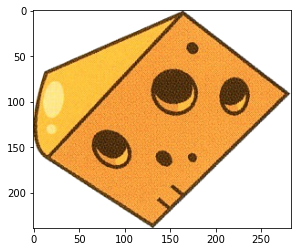

In [9]:
print(train_labels[0])
plt.imshow(train_images[0])
print(ref[1][np.where(ref[0] == train_labels[0])])

## Print test example

56
['ampoule\n']


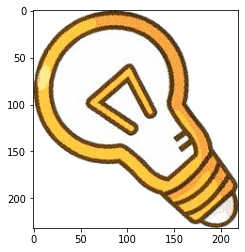

In [10]:
print(test_labels[0])
plt.imshow(test_images[0])
print(ref[1][np.where(ref[0] == test_labels[0])])

## Find all indices for a label

In [11]:
def find_all_labeled(label, labels):
    """
    Returns all indices of element like `label` in `labels`

    Parameters
    ----------
    label: str
        Searched label
    
    labels: [str]
        Dataset's labels
    """
    indices = []
    for i in range(labels.size):
        if labels[i] == label:
            indices.append(i)
    return indices

find_all_labeled(train_labels[0], train_labels)

[0, 22, 96]

## Summary

If you executed all of the above, you defined the following variables:

```python
ref # couple:
    ref[0] # labels' identifiers
    ref[1] # labels

train_labels # train dataset's images' identifiers for labels

train_images # train dataset's images

test_labels # test dataset's images' identifiers for labels

test_images # test dataset's images
```

## Color histogram
### 1. Color quantization

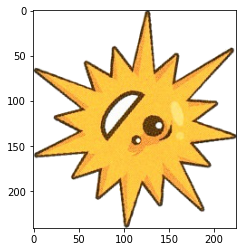

In [12]:
def get_each_image() :
    """
    Return one image of each type with corresponding labels
    """
    PATH_TO_RESOURCES = "ressources/train"
    images = []
    dirs = os.listdir(PATH_TO_RESOURCES)
    labels = []
    for name_dir in dirs : 
        if name_dir == "labels.txt" :
            continue
        actual_path = os.path.join(PATH_TO_RESOURCES, name_dir)
        img_name = os.listdir(actual_path)[0]
        img = cv2.imread(os.path.join(actual_path, img_name));
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB);
        images.append(img)
        labels.append(name_dir)
    return images, labels

each_images, each_labels = get_each_image()
plt.imshow(each_images[52])

(250, 14250, 3)

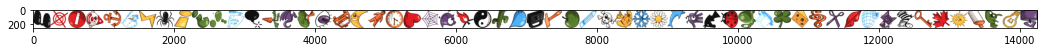

In [13]:
def create_poster(images) : 
    """
    Return a poster containing all images and a corresponding mask
    
    Parameters
    ----------        
    images: [image]
        Dataset's images
    """
    sizeImg = 250
    img0 = cv2.resize(images[0], (sizeImg, sizeImg))
    poster = img0
    first = True
    for img in images : 
        if first : 
            first = False
            continue
        img = cv2.resize(img, (sizeImg, sizeImg))
        poster = cv2.hconcat([poster, img])
    
    # Create a mask for the poster generated 
    poster_mask = np.zeros(poster.shape[0] * poster.shape[1])
    for i in range(poster.shape[0]) : 
        for j in range(poster.shape[1]) : 
            poster_mask[i * poster.shape[0] +  j] = np.all(poster[i, j] != 255)
    
    return poster, poster_mask

poster, poster_mask = create_poster(each_images)
plt.figure(figsize=(18,18))
plt.imshow(poster)
poster.shape

In [14]:
from sklearn.cluster import KMeans

def train_kmeans(poster, nb_colors) :
    """
    'Train' kmeans using poster's colors 
    Parameters
    ----------
    poster: image
        
    nb_colors: int
        Number of clusters for kmeans
    """
    plane_poster = poster.reshape(len(poster) * len(poster[0]), 3)
    kmeans = KMeans(n_clusters=nb_colors, random_state=0)
    kmeans.fit(plane_poster)
    kmeans.cluster_centers_
    label_map = kmeans.predict(plane_poster)
    return kmeans, label_map

kmeans, label_map = train_kmeans(poster, 10)

<BarContainer object of 10 artists>

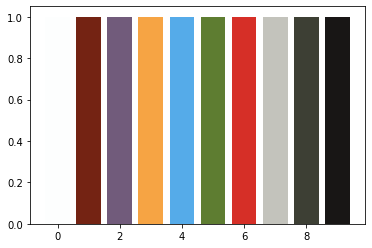

In [15]:
color_lut = np.uint8(kmeans.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.ones(len(color_lut)), 
         color=color_lut/255)

### 2. Color histograms

In [16]:
def reduce_color(img, kmeans) : 
    """
    Reduce the colors in an image
    
    Parameters
    ----------
    img: image
        Reference image
    kmeans: Kmeans
        kmeans used to determine new colors
    """
    newImg = np.zeros_like((0, 0, 0), shape=img.shape)
    prediction = kmeans.predict(img.reshape(len(img) * len(img[0]), 3))
    histo = np.zeros(len(kmeans.cluster_centers_))
    for i in range(len(img)) : 
        for j in range(len(img[0])) :
            if img[i, j][0] == 255 and img[i, j][1] == 255 and img[i, j][2] == 255: 
                newImg[i, j] = [255, 255,255]
            else :
                newImg[i, j] = kmeans.cluster_centers_[prediction[i * len(img[0]) + j]]
                histo[prediction[i * len(img[0]) + j]] += 1
    return newImg, histo

def normalize_histogram(histo) : 
    """
    Normalize histogram
    
    Parameter
    ----------
    histo: [int]
        image histogram
    """
    nbPixels = np.sum(histo)
    for i in range(len(histo)) : 
        if histo[i] != 0 :
            histo[i] = histo[i] / nbPixels
    return histo

In [17]:
# Reduce color of all images
images_quant = []
color_histograms = []
for i in range(len(each_images)) : 
    newImg, histo = reduce_color(each_images[i], kmeans)
    images_quant.append(newImg)
    # Normalise histogram
    histo = normalize_histogram(histo)
    color_histograms.append(histo) 

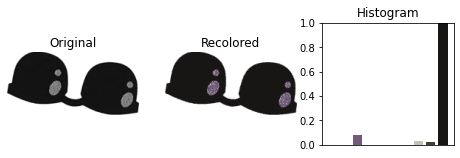

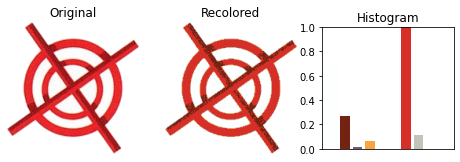

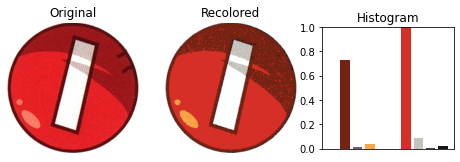

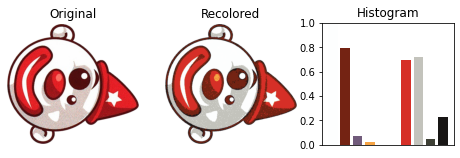

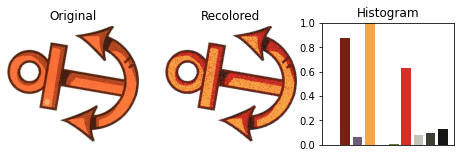

In [18]:
# Show some color histograms with colors!
colors_for_bars = color_lut/255  # matplotlib colors are RGB values scaled to [0,1]
for ii in range(5):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(each_images[ii])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(images_quant[ii])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[ii])), 
            color_histograms[ii]/color_histograms[ii].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

### Test without classifier just using histogram comparison

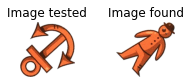

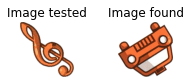

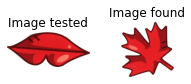

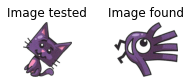

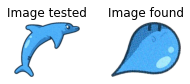

Accuracy:  0.96


In [19]:
import scipy as sc

good_result = 0
for i in range(len(test_images)) : 
    test_img = test_images[i]
    test_img_recolored, test_histo = reduce_color(test_img, kmeans)
    test_histo = normalize_histogram(test_histo)
    minimal_distance = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[0])))
    best_index = 0
    
    for j in range(1, len(color_histograms)) :
        dist = sc.spatial.distance.pdist(np.vstack((test_histo, color_histograms[j])))
        if dist < minimal_distance : 
            minimal_distance = dist 
            best_index = j
    # Check que le result est bon
    if test_labels[i] == each_labels[best_index] :
        good_result += 1
    else :
        plt.figure(figsize=(5,1))
        plt.subplot(1,3, 1)
        plt.imshow(test_img)
        plt.axis('off'); plt.title("Image tested")
        plt.subplot(1,3,2)
        plt.imshow(each_images[best_index])
        plt.axis('off'); plt.title("Image found")
        plt.show()
    
accuracy = good_result / len(test_images)
print("Accuracy: ", round(accuracy, 2))

### Test linear classifier

In [20]:
# Get images histograms
def get_images_histograms(images) : 
    histograms = []
    for i in range(len(images)) : 
        actual_img = images[i]
        actual_img_recolored, img_histo = reduce_color(actual_img, kmeans)
        actual_histo = normalize_histogram(img_histo)
        histograms.append(actual_histo)
    return histograms

train_histograms = get_images_histograms(train_images)
test_histograms = get_images_histograms(test_images)

In [21]:
import sklearn as sk
import sklearn.dummy
import sklearn.ensemble

def classifier_test(clf, clf_name) : 
    clf.fit(train_histograms, train_labels)
    label_pred = clf.predict(test_histograms)

    good = 0
    for i in range(len(label_pred)) : 
        if label_pred[i] == test_labels[i] :
            good += 1
    accuracy = good / len(label_pred)
    print(clf_name + '. Accuracy:', round(accuracy, 3))

print("Test de différents classifiers :\n")
clf = sk.svm.LinearSVC()
classifier_test(clf, "Linear SVC")
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=1)
classifier_test(clf, "KNeighbors (1 neighbor)")
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
classifier_test(clf, "KNeighbors (3 neighbors)")
classifier_test(sk.dummy.DummyClassifier(), "Dummy")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=10), "RandomForest (10 estimators)")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=100), "RandomForest (100 estimators)")
classifier_test(sk.ensemble.RandomForestClassifier(n_estimators=57), "RandomForest (57 estimators)")


Test de différents classifiers :

Linear SVC. Accuracy: 0.526
KNeighbors (1 neighbor). Accuracy: 1.0
KNeighbors (3 neighbors). Accuracy: 0.947
Dummy. Accuracy: 0.018
RandomForest (10 estimators). Accuracy: 0.947
RandomForest (100 estimators). Accuracy: 0.991
RandomForest (57 estimators). Accuracy: 0.991


In [22]:
clf = sk.neighbors.KNeighborsClassifier(n_neighbors=5)
clf.fit(train_histograms, train_labels)
probas = clf.predict_proba(test_histograms)

print("Errors found and corresponding probabilities.\n")
for i in range(len(probas)) :
    label_pred = clf.classes_[np.where(probas[i] == np.amax(probas[i]))]
    if label_pred[0] != test_labels[i] :
        labels_proba = ""
        for j in range(len(probas[0])) : 
            if probas[i][j] > 0 : 
                label = clf.classes_[j]
                labels_proba += label + "/" + str(probas[i][j]) + "; "
        print("Label wanted:", test_labels[i], ". Labels get/proba: ", labels_proba)

Errors found and corresponding probabilities.

Label wanted: 45 . Labels get/proba:  18/0.6; 45/0.4; 
Label wanted: 37 . Labels get/proba:  28/0.6; 37/0.4; 
Label wanted: 49 . Labels get/proba:  15/0.4; 38/0.2; 46/0.2; 49/0.2; 
Label wanted: 08 . Labels get/proba:  01/0.6; 08/0.4; 
Label wanted: 37 . Labels get/proba:  28/0.6; 37/0.4; 
Label wanted: 43 . Labels get/proba:  31/0.6; 43/0.4; 


## Shape matching
### 1. Hu moments
#### Image treatment

In [23]:
def grayscale(img):
    return np.dot(img[..., :3], [.299, .587, .114])

In [38]:
def inverted(img):
    return np.full(img.shape, 255) - img

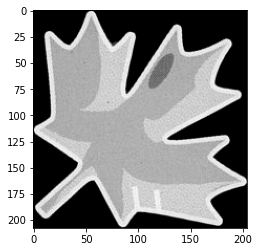

In [40]:
plt.imshow(inverted(grayscale(test_images[11])), cmap = 'gray')

#### Moments

In [41]:
def raw_moment(i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += x ** i * y ** j * img[y][x]
    return moment

In [42]:
def central_moment(i, j, img):
    avg_moment = raw_moment(0, 0, img)
    x_centroid = raw_moment(1, 0, img) / avg_moment
    y_centroid = raw_moment(0, 1, img) / avg_moment
    
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - x_centroid) ** i * (y - y_centroid) ** j * img[y][x]
    return moment

In [43]:
def central_moment_opt(centroid, i, j, img):
    moment = 0
    for y in range(len(img)):
        for x in range(len(img[0])):
            moment += (x - centroid[0]) ** i * (y - centroid[1]) ** j * img[y][x]
    return moment

In [44]:
def scale_invariant_moment(i, j, img):
    assert i + j >= 2
    return central_moment(i, j, img) / central_moment(0, 0, img) ** (1 + (i + j) / 2)

In [45]:
def scale_invariant_moment_opt(centroid, c0, i, j, img):
    assert i + j >= 2
    return central_moment_opt(centroid, i, j, img) / c0 ** (1 + (i + j) / 2)

#### Hu Moments

In [46]:
def hu_moments(img):
    img_gray = inverted(grayscale(img))
    
    nu20 = scale_invariant_moment(2, 0, img_gray)
    nu11 = scale_invariant_moment(1, 1, img_gray)
    nu02 = scale_invariant_moment(0, 2, img_gray)
    nu30 = scale_invariant_moment(3, 0, img_gray)
    nu21 = scale_invariant_moment(2, 1, img_gray)
    nu12 = scale_invariant_moment(1, 2, img_gray)
    nu03 = scale_invariant_moment(0, 3, img_gray)
    
    I0 = (nu20 + nu02)
    
    I1 = ((nu20 - nu02) ** 2 +
          4 * nu11 ** 2)
    
    I2 = ((nu30 - 3 * nu12) ** 2 +
          (3 * nu21 - nu03) ** 2)
    
    I3 = ((nu30 + nu12) ** 2 +
          (nu21 + nu03) ** 2)
    
    I4 = ((nu30 - 3 * nu12) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) +
          (3 * nu21 - nu03) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    I5 = ((nu20 - nu02) * ((nu30 + nu12) ** 2 - (nu21 + nu03) ** 2) +
          4 * nu11 * (nu30 + nu12) * (nu21 + nu03))
    
    I6 = ((3 * nu21 - nu03) * (nu30 + nu12) *
          ((nu30 + nu12) ** 2 - 3 * (nu21 + nu03) ** 2) -
          (nu30 - 3 * nu12) * (nu21 + nu03) *
          (3 * (nu30 + nu12) ** 2 - (nu21 + nu03) ** 2))
    
    return [I0, I1, I2, I3, I4, I5, I6]

In [47]:
def hu_moments_opt(img):
    img_gray = inverted(grayscale(img))
    
    avg = raw_moment(0, 0, img_gray)
    centroid = (raw_moment(1, 0, img_gray) / avg, raw_moment(0, 1, img_gray) / avg)
    
    c0 = central_moment_opt(centroid, 0, 0, img_gray)
    
    nu20 = scale_invariant_moment_opt(centroid, c0, 2, 0, img_gray)
    nu11 = scale_invariant_moment_opt(centroid, c0, 1, 1, img_gray)
    nu02 = scale_invariant_moment_opt(centroid, c0, 0, 2, img_gray)
    nu30 = scale_invariant_moment_opt(centroid, c0, 3, 0, img_gray)
    nu21 = scale_invariant_moment_opt(centroid, c0, 2, 1, img_gray)
    nu12 = scale_invariant_moment_opt(centroid, c0, 1, 2, img_gray)
    nu03 = scale_invariant_moment_opt(centroid, c0, 0, 3, img_gray)
    
    hu = np.zeros(7)
    
    t0 = nu30 + nu12;
    t1 = nu21 + nu03;

    q0 = t0 * t0
    q1 = t1 * t1;

    n4 = 4 * nu11;
    s = nu20 + nu02;
    d = nu20 - nu02;

    hu[0] = s;
    hu[1] = d * d + n4 * nu11;
    hu[3] = q0 + q1;
    hu[5] = d * (q0 - q1) + n4 * t0 * t1;

    t0 *= q0 - 3 * q1;
    t1 *= 3 * q0 - q1;

    q0 = nu30 - 3 * nu12;
    q1 = 3 * nu21 - nu03;

    hu[2] = q0 * q0 + q1 * q1;
    hu[4] = q0 * t0 + q1 * t1;
    hu[6] = q1 * t0 - q0 * t1;
    
    return hu

In [48]:
def compute_moments_diff(hu_1, hu_2):
    diff = 0
    for i in range(7):
        diff += (hu_2[i] - hu_1[i]) ** 2
        
    return math.sqrt(diff)

In [49]:
def moments_from(images):
    hu_mo = np.zeros((len(images), 7))
    for ii in range(len(images)):
        hu_mo[ii] = hu_moments_opt(images[ii])
    return hu_mo * 1e6

#### Classifiers

In [50]:
train_moments = moments_from(train_images)

In [51]:
test_moments = moments_from(test_images)

In [52]:
from sklearn.dummy import DummyClassifier

km = DummyClassifier().fit(train_moments, train_labels) # 56%
km.score(test_moments, test_labels)

0.017543859649122806

In [53]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

km = make_pipeline(StandardScaler(), LinearSVC(max_iter=1500)).fit(train_moments, train_labels) # 29%
km.score(test_moments, test_labels)

/home/qwarks/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.2807017543859649

In [54]:
from sklearn.neighbors import KNeighborsClassifier

km = KNeighborsClassifier(n_neighbors=6).fit(train_moments, train_labels) # 46%
km.score(test_moments, test_labels)

0.47368421052631576

In [55]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

km = make_pipeline(StandardScaler(), SVC()).fit(train_moments, train_labels) # 87%
km.score(test_moments, test_labels)

0.9122807017543859

In [56]:
from sklearn.ensemble import RandomForestClassifier

km = RandomForestClassifier().fit(train_moments, train_labels) # 100%
km.score(test_moments, test_labels)

1.0

In [57]:
print(km.predict_proba(test_moments)[2])
print(km.classes_)
print(km.predict(test_moments)[2])

[0.00090763 0.00163224 0.00095061 0.21145698 0.59270763 0.
 0.         0.00215494 0.         0.00806314 0.0054069  0.
 0.00163615 0.         0.00242292 0.00258907 0.00617532 0.00602987
 0.         0.00352653 0.00173106 0.0022835  0.00145693 0.00450013
 0.01727821 0.00170554 0.00468087 0.01566722 0.00101536 0.
 0.00163387 0.         0.00343072 0.03637815 0.00266142 0.00133413
 0.         0.00246698 0.00374671 0.00194304 0.00820538 0.
 0.00218806 0.00419438 0.         0.00665502 0.00300863 0.
 0.00213986 0.00400828 0.         0.000645   0.00374246 0.
 0.00833493 0.00459651 0.00270774]
['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28'
 '29' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42'
 '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56'
 '57']
05


## Early Fusion

### Color histogram & Hu moments

In [58]:
train_early = [np.concatenate((train_histograms[i], train_moments[i])) for i in range(len(train_moments))]
test_early = [np.concatenate((test_histograms[i], test_moments[i])) for i in range(len(test_moments))]

In [59]:
from sklearn.dummy import DummyClassifier

early_classifier = DummyClassifier().fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

0.017543859649122806

In [60]:
from sklearn.neighbors import KNeighborsClassifier

early_classifier = KNeighborsClassifier(n_neighbors=4).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

0.45614035087719296

In [61]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

early_classifier = make_pipeline(StandardScaler(), SVC()).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

0.9912280701754386

In [62]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

early_classifier = make_pipeline(StandardScaler(), LinearSVC(max_iter=1500)).fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

/home/qwarks/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.9824561403508771

In [63]:
from sklearn.ensemble import RandomForestClassifier

early_classifier = RandomForestClassifier().fit(train_early, train_labels)
early_classifier.score(test_early, test_labels)

1.0

## Late Fusion

### Color histogram & Hu moments

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

col_classifier = KNeighborsClassifier(n_neighbors=5).fit(train_histograms, train_labels)
hu_classifier = RandomForestClassifier().fit(train_moments, train_labels)

In [65]:
col_results = col_classifier.predict_proba(test_histograms), col_classifier.classes_
hu_results = hu_classifier.predict_proba(test_moments), hu_classifier.classes_

In [66]:
results = col_results[0] + hu_results[0], col_results[1]

final = np.empty(len(results[0]), dtype='object')
for ii in range(results[0].shape[0]):
    imax = results[0][ii]
    final[ii] = col_results[1][imax.argmax()]

In [67]:
#Classifier save for test program
import joblib 

joblib.dump(col_classifier, "col.clf")
joblib.dump(hu_classifier, "hu.clf")

['hu.clf']